# Phase Diagram for the Syntectic System

Here we develop a free energy functional and phase diagram for a system with a syntectic transition

## Ideal Free Energy

---

The ideal free energy per unit area is of the following form

$$
\mathcal{F}_{id}[n] = \frac{1}{V_{cell}}\int_{cell} 
\frac{1}{2}n(x,y)^2 - \frac{\eta}{6} n(x,y)^3 + \frac{\chi}{12} n(x,y)^4
$$

To compute the phase diagram we use a variational method where we expand the reduced density, $n$, in the most general fourier series that is consistent with the symmetry of the bravais lattice.

$$
n(x,y) = n_0 + A_1 n_1(x,y) + A_2 n_2(x,y) + ...
$$

We then expand out the ansatz and compute each integral over the unit-cell numerically to find the amplitude equation for the ideal free energy

In [1]:
using PyPlot
using Interact
using Maxima
using Optim
using PhaseDiagrams

In [2]:
f_ideal = m"n^2/2 - η*n^3/6 + χ*n^4/12"

 
                                4      3      2
                               n  χ   n  η   n
                               ---- - ---- + --
                                12     6     2

In [3]:
n = m"n0 + 2*A*n1"            # + A[2]*n2"

f_ideal = subst(n, :n, f_ideal)

 
                          4                  3                  2
             (2 A n1 + n0)  χ   (2 A n1 + n0)  η   (2 A n1 + n0)
             ---------------- - ---------------- + --------------
                    12                 6                 2

In [4]:
f_ideal = expand(f_ideal)

 
    4   4        3      3                            3          4
 4 A  n1  χ   8 A  n0 n1  χ      2   2   2     2 A n0  n1 χ   n0  χ
 ---------- + ------------- + 2 A  n0  n1  χ + ------------ + -----
     3              3                               3          12
      3   3                                    3                              2
   4 A  n1  η      2      2         2        n0  η      2   2               n0
 - ---------- - 2 A  n0 n1  η - A n0  n1 η - ----- + 2 A  n1  + 2 A n0 n1 + ---
       3                                       6                             2

In [5]:
n1 = m"cos(4*%pi/sqrt(3)*(sqrt(3)*x/2 - y/2)) + 
       cos(4*%pi/sqrt(3)*(sqrt(3)*x/2 + y/2)) + 
       cos(4*%pi/sqrt(3)*y)"

n2 = m"cos(4*%pi*x) +
       cos(4*%pi*(x/2 + sqrt(3)*y/2)) + 
       cos(4*%pi*(-x/2 + sqrt(3)*y/2))"

f_ideal = subst(n1, :n1, f_ideal)
#f_ideal = subst(n2, :n2, f_ideal);

In [6]:
F_ideal = "integrate(integrate($f_ideal, x, 0, 1), y, 0, sqrt(3)/2)" |> MExpr;

In [7]:
F_ideal = mcall(F_ideal)

 
            3/2       4       7/2      2   2       5/2      3
 ((- ((- 2 3    %pi n0 ) - 8 3    %pi A  n0  - 32 3    %pi A  n0
       7/2      4           3/2       3      7/2      2          5/2      3
 - 20 3    %pi A ) χ) - (4 3    %pi n0  + 8 3    %pi A  n0 + 16 3    %pi A ) η
      5/2       2      7/2      2
 + 4 3    %pi n0  + 8 3    %pi A )/(144 %pi)

In [8]:
F_ideal = ratsimp(F_ideal)
F_ideal = "$F_ideal/(sqrt(3)/2)" |> MExpr |> mcall
F_ideal = ratsimp(F_ideal)
F_ideal = float(F_ideal)
F_ideal = expand(F_ideal)

 
                       4          2   2          3             4
 0.08333333333333333 n0  χ + 3.0 A  n0  χ + 4.0 A  n0 χ + 7.5 A  χ
                                3          2             3           2        2
         - 0.1666666666666667 n0  η - 3.0 A  n0 η - 2.0 A  η + 0.5 n0  + 3.0 A

In [9]:
F_id_exp = parse(F_ideal)                # Make julia expression of the ideal free energy
@eval F_id(η, χ, n0, A) = $F_id_exp     # Make julia function from the expression

F_id (generic function with 1 method)

## Free Energy of Mixing

The free energy of mixing is of the following form:

$$
    \mathcal{F}_{mix}[c] = \frac{\omega}{V_{cell}}\int_{cell} 
    (1 + n_0)\left(c \log\left(\frac{c}{c_0}\right) + 
    (1-c) \log\left(\frac{1-c}{1-c_0}\right)\right) + \frac{\epsilon(T)}{2}(c-c_0)^2
$$

In equilibrium we can assume that the concentration is constant so the integral just cancels the factor of the volume of the unit cell. The term $\epsilon(T)$ is the enthaply of mixing term which we model as, 

$$
\epsilon(T) = -4 + \epsilon_0 (T - T_0),
$$

where $T_0$ is the spinodal temperature of the liquid

In [10]:
F_mix(c, T, n₀, ϵ₀, Tc, ω) = ω*((1+n₀)*(c*log(2.0*c) + (1-c)*log(2.0*(1-c))) + (-4.0 + ϵ₀*(T-Tc))/2*(c-0.5)^2)

F_mix (generic function with 1 method)

## Correlation functions

There are a variety of effective pair correlation functions we can choose from. Here is one of them from the original xpfc paper

In [42]:
const k′ = 2π
const α = 0.8
const T₀ = 3.76057
const αc = 0.5
const c₀ = 0.5

C_eff(k, c, T) = exp(-(c - 1.0)^2 / (2. * αc^2)) * exp(-T / T₀) * exp(-(k - k′)^2 / (2. * α^2))

C_eff (generic function with 1 method)

## Excess Free Energy

The excess free energy term in the binary phase field crystal model is the form

$$
\mathcal{F}_{ex}[n, c] = -\frac{1}{2 V_{cell}}\int_{cell} dr \int dr^\prime n(r) C_{eff}(r, r^\prime; c) n(r^\prime)
$$

Most of the modes in the amplitude expansion cancel out but we're left with the following at the end of the day:

$$
\mathcal{F}_{ex}[n, c] = -\frac{1}{2 V_{cell}}(n_0^2 C_{eff}(k=0, c) + 6 A_1^2 C_{eff}(k=k_1, c) + 6 A_2^2 C_{eff}(k=k_2, c))
$$

In [43]:
function F_ex(c, T, A)
    k = k′
    return (-3.0*A^2*C_eff(k, c, T))       # + 6.0*A[2]^2*C_eff(k[2], c, T))
end

F_ex (generic function with 1 method)

## Total free energy

The total free energy is sum of all the above terms

In [44]:
F(c, T, η, χ, ϵ₀, Tc, ω, n₀, A) = F_mix(c, T, n₀, ϵ₀, Tc, ω) + F_ex(c, T, A)+ F_id(η, χ, n₀, A) 

F (generic function with 3 methods)

In [45]:
function F(c, T, η, χ, ϵ₀, Tc, ω, n₀)
    sol = optimize(A -> F(c, T, η, χ, ϵ₀, Tc, ω, n₀, A), 0.0, 10.0)
    #println("Amplitude at concentation $c and temperature $T is $(sol.minimum)")
    return sol.minimum
end

F (generic function with 3 methods)

In [46]:
const η = 2.0
const χ = 1.0
const ϵ₀ = 30.0
const Tc = 0.15
const ω = 0.3
const n₀ = 0.05

F(c, T) = F(c, T, η, χ, ϵ₀, Tc, ω, n₀)

F (generic function with 3 methods)

In [47]:
function make_phase_diagram(FF, crnge, Trnge)
    # f is the free energy function
    # crange is the range of concentrations
    # Trange is the range of temperatures
    
    T_vals = Float64[] 
    c_vals = Float64[]
    
    c = collect(crnge)
    T = collect(Trnge)
    
    f = Array(Float64, length(c))
    
    for t in 1:length(T)
        for cc in 1:length(c)
            f[cc] = FF(c[cc], T[t])
        end
        arr = commontangent(f)
        for domain in arr
            for point in domain
                push!(T_vals, T[t])
                push!(c_vals, c[point])
            end
        end
    end
    return T_vals, c_vals
end

make_phase_diagram (generic function with 1 method)

In [48]:
# Total phase diagram

crnge = 0.001:0.001:0.999
Trnge = 0.00:0.010:1.00

T_vals, c_vals = make_phase_diagram(F, crnge, Trnge)

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{Float64}, ::Int64) at ./deprecated.jl:57
 [3] make_phase_diagram(::#F, ::StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}, ::StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}) at ./In[47]:12
 [4] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/nsmith/.julia/v0.6/IJulia/src/execute_request.jl:160
 [5] eventloop(::ZMQ.Socket) at /home/nsmith/.julia/v0.6/IJulia/src/eventloop.jl:8
 [6] (::IJulia.##11#14)() at ./task.jl:335
while loading In[48], in expression starting on line 6


([0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.04, 0.04  …  0.96, 0.96, 0.97, 0.97, 0.98, 0.98, 0.99, 0.99, 1.0, 1.0], [0.014, 0.976, 0.016, 0.972, 0.019, 0.968, 0.022, 0.964, 0.026, 0.959  …  0.812, 0.841, 0.815, 0.844, 0.819, 0.847, 0.823, 0.851, 0.827, 0.855])

In [49]:
# Liquid free energy

crange = 0.001:0.001:0.999
trange = 0.00:0.010:0.60

Fₗ(c, T, η, χ, ϵ₀, T₀, ω, n₀) = F_mix(c, T, n₀, ϵ₀, T₀, ω) + F_id(η, χ, n₀, 0.0) 
Fₗ(c, T) = Fₗ(c, T, η, χ, ϵ₀, Tc, ω, n₀)

T_s, c_s = make_phase_diagram(Fₗ, crange, trange)

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{Float64}, ::Int64) at ./deprecated.jl:57
 [3] make_phase_diagram(::#Fₗ, ::StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}, ::StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}) at ./In[47]:12
 [4] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/nsmith/.julia/v0.6/IJulia/src/execute_request.jl:160
 [5] eventloop(::ZMQ.Socket) at /home/nsmith/.julia/v0.6/IJulia/src/eventloop.jl:8
 [6] (::IJulia.##11#14)() at ./task.jl:335
while loading In[49], in expression starting on line 9


([0.0, 0.0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.04, 0.04  …  0.1, 0.1, 0.11, 0.11, 0.12, 0.12, 0.13, 0.13, 0.14, 0.14], [0.02, 0.98, 0.024, 0.976, 0.028, 0.972, 0.033, 0.967, 0.039, 0.961  …  0.12, 0.88, 0.15, 0.85, 0.192, 0.808, 0.254, 0.746, 0.369, 0.631])

In [57]:
f = figure()
withfig(f) do
    scatter(c_vals, T_vals, s=2)
    scatter(c_s, T_s, s=2)
    grid(false)
    xlim(0, 1)
    ylim(0.00, 0.40)
    xlabel(L"Concentration $(c)$")
    ylabel(L"Temperature $(T)$")
end

savefig("Nanocrystalline Phase Diagram.svg")

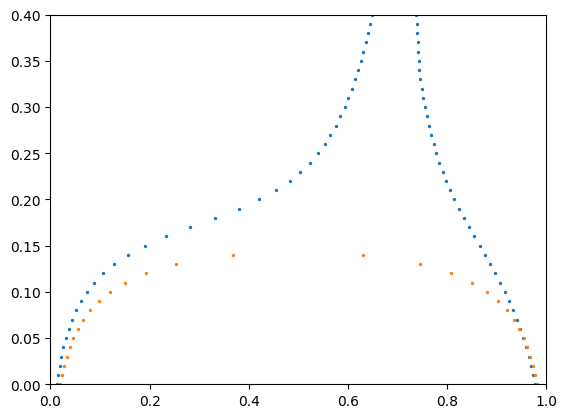

In [55]:
scatter(c_vals, T_vals, s=2)
scatter(c_s, T_s, s=2)
xlim(0, 1)
ylim(0, 0.4)
grid(false)

## Spinodal Line

The spinodal line is defined by the inflexion point of the liquid free energy.